<a href="https://colab.research.google.com/github/its-amrita-sarkar-01/Bank-Marketing-Effectiveness-Prediction/blob/main/Bank_Marketing_Effectiveness_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Description
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe a term deposit (variable y).

## Data Description
Input variables:

Bank Client data:

age (numeric) job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

default: has credit in default? (categorical: 'no','yes','unknown')

housing: has housing loan? (categorical: 'no','yes','unknown')

loan: has personal loan? (categorical: 'no','yes','unknown')

Related with the last contact of the current campaign:

contact: contact communication type (categorical: 'cellular','telephone')

month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Other attributes:

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

previous: number of contacts performed before this campaign and for this client (numeric)

poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Social and economic context attributes

emp.var.rate: employment variation rate - quarterly indicator (numeric)

cons.price.idx: consumer price index - monthly indicator (numeric)

cons.conf.idx: consumer confidence index - monthly indicator (numeric)

euribor3m: euribor 3 month rate - daily indicator (numeric)

nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

y - has the client subscribed a term deposit? (binary: 'yes','no')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries

import numpy as np
import pandas as pd
import scipy.stats
import missingno
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.express as ex
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Capstone Project/bank-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# Checking shape of dataset

print('Bank Marketting Effectiveness dataset - rows:', df.shape[0],' columns:', df.shape[1])

Bank Marketting Effectiveness dataset - rows: 45211  columns: 17


In [ ]:
# Checking for the null values

df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There is no null value present in the given dataset

In [ ]:
# Rename default and poutcome to has_credit_card and prev_outcome 

df.rename(columns = {'default': 'has_credit_card', 'poutcome': 'prev_outcome'}, inplace = True)

In [ ]:
# List of categorical columns

categorical_features = [col for col 
                            in dict(df.dtypes) 
                            if dict(df.dtypes)[col] 
                            in ['object']]

# Categorical features and their number of levels

print(df[categorical_features].nunique())

job                12
marital             3
education           4
has_credit_card     2
housing             2
loan                2
contact             3
month              12
prev_outcome        4
y                   2
dtype: int64


In [ ]:
# Display all categorical values

for col in list(df.columns[df.dtypes == 'object']):
    print('\n',col+' :')
    print(df[col].unique())


 job :
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

 marital :
['married' 'single' 'divorced']

 education :
['tertiary' 'secondary' 'unknown' 'primary']

 has_credit_card :
['no' 'yes']

 housing :
['yes' 'no']

 loan :
['no' 'yes']

 contact :
['unknown' 'cellular' 'telephone']

 month :
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

 prev_outcome :
['unknown' 'failure' 'other' 'success']

 y :
['no' 'yes']


In [ ]:
# List of numerical columns

num_features = df.columns[df.dtypes != 'object']

# Numerical features and their number of levels

print(df[num_features].nunique())

age           77
balance     7168
day           31
duration    1573
campaign      48
pdays        559
previous      41
dtype: int64


In [ ]:
# generate count statistics of duplicate entries

if (len(df[df.duplicated()]) > 0):
    print('No. of duplicated entries: ', len(df[df.duplicated()]))
    print(df[df.duplicated(keep = False)].sort_values(by = list(df.columns)).head())
else:
    print('No duplicated entries found')

No duplicated entries found


In [ ]:
# Statistical Summary of the dataset

df.describe([0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,50%,80%,90%,95%,99%,max
age,45211.0,40.936210,10.618762,18.0,39.0,51.0,56.0,59.0,71.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,448.0,1859.0,3574.0,5768.0,13164.9,102127.0
day,45211.0,15.806419,8.322476,1.0,16.0,24.0,28.0,29.0,31.0,31.0
duration,45211.0,258.163080,257.527812,0.0,180.0,368.0,548.0,751.0,1269.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,2.0,4.0,5.0,8.0,16.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,185.0,317.0,370.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,2.0,3.0,8.9,275.0


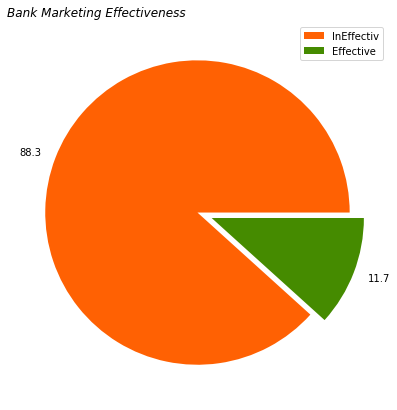

In [ ]:
# Pie plot of the dependent variable

df_count = (df.y.value_counts())
total = sum(df_count)
df_percentage = (df_count)/total*100
plt.figure(figsize = (7,7))
plt.pie(df_percentage,explode=(0,0.1), labels = [round(i,2) for i in (list(df_percentage))],colors=['#FF6103','#458B00'])
plt.title(label = 'Bank Marketing Effectiveness',fontstyle = 'italic',loc = 'left')
plt.legend(labels = ['InEffectiv','Effective']) 
plt.show()

### The dataset is imbalanced. 88.3% of the dependent variable is ineffective i.e the customer doesnot subscribed to the term deposit and 11.7% is otherwise.

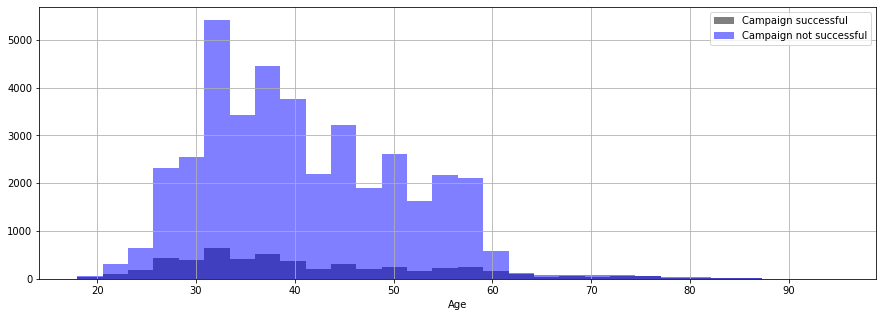

In [ ]:
# Comparing age distribution between converted vs unconverted clients

plt.figure(figsize = (15, 5))

df[df['y'] == 'yes']['age'].hist(alpha = 0.5,
                                 color = 'black',
                                 bins = 30,
                                 label = 'Campaign successful')

df[df['y'] == 'no']['age'].hist(alpha = 0.5,
                                color = 'blue',
                                bins = 30,
                                label = 'Campaign not successful')
plt.legend()
plt.xlabel('Age')
plt.show();

### Campaign seem to be most successful among younger < 20 years old and older clients > 60 years old.

In [ ]:
# Mean age by profession

df[['job', 'age']].groupby(by = ['job'], axis = 0).mean().sort_values(by = 'age', ascending = True)

,age
job,
student,26.542644
services,38.740250
admin.,39.289886
technician,39.314598
blue-collar,40.044081
management,40.449567
self-employed,40.484484
unemployed,40.961627
entrepreneur,42.190989


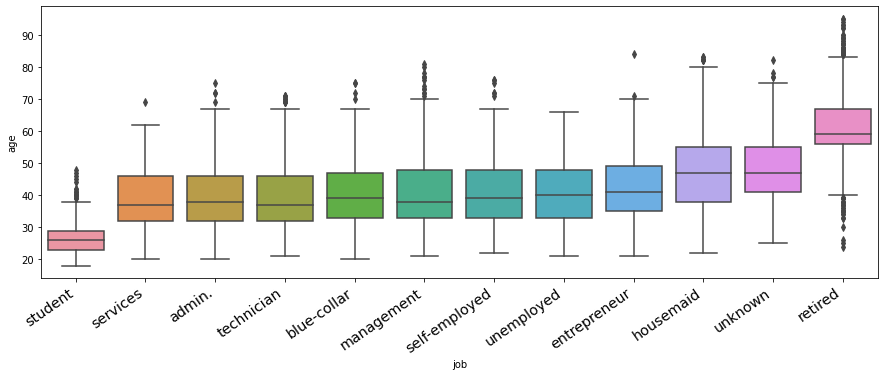

In [ ]:
# Plot age distribution of clients by profession

job_order = df[['job', 'age']].groupby(by = ['job'], axis = 0).mean().sort_values(by = 'age', ascending = True).index

plt.figure(figsize = (15, 5))
sns.boxplot(x ='job', y ='age', data = df, order = job_order)
sns.set(font_scale = 1)
plt.xticks(
    rotation = 35, 
    horizontalalignment = 'right',
    fontweight ='light',
    fontsize = 'large');

### There are apparent outliers among both professions (young retirees and older students.

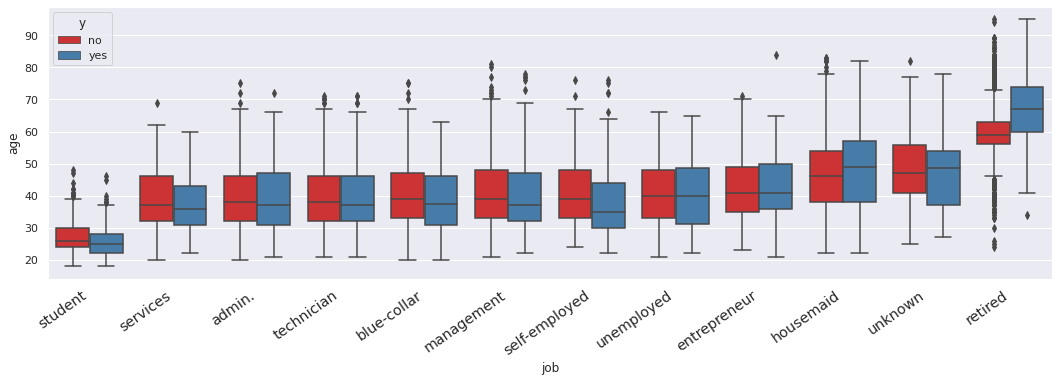

In [ ]:
# Plot age distribution of clients by profession and campaign result

plt.figure(figsize = (18, 5))
sns.boxplot(x = 'job', y = 'age', hue = 'y', data = df, order = job_order, palette = "Set1")
sns.set(font_scale = 1)
plt.xticks(
    rotation = 35, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'large');

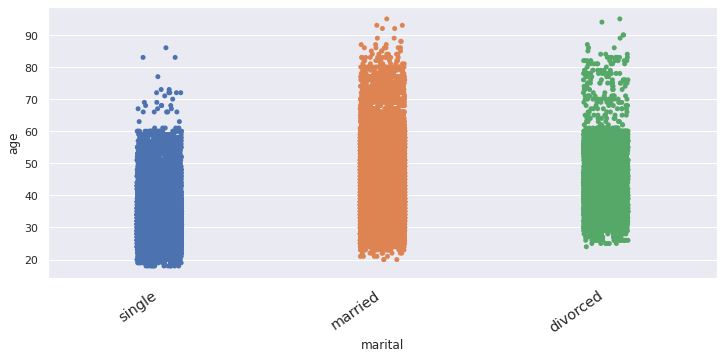

In [ ]:
# Plot age distribution of clients by marital status

marital_order = df[['marital', 'age']].groupby(by = ['marital'], axis = 0).mean().sort_values(by = 'age', ascending = True).index

plt.figure(figsize = (12, 5))
sns.stripplot(x = 'marital', y = 'age', order = marital_order, data = df)
sns.set(font_scale = 1)
plt.xticks(
    rotation = 35, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'large');

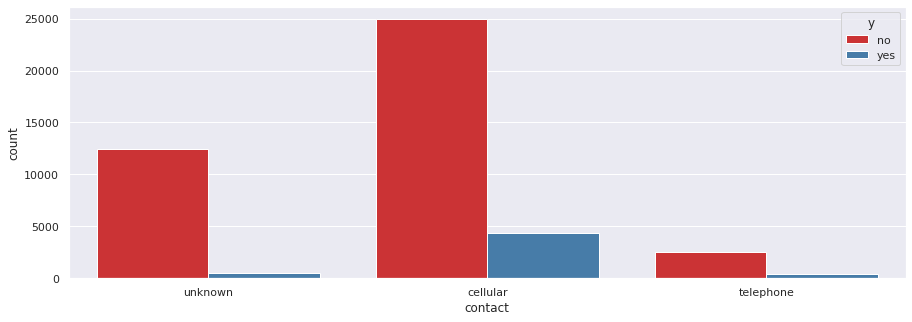

In [ ]:
# Campaign success based on whether client's contact information availability (cellular vs. telephone)

plt.figure(figsize = (15,5))
sns.set(font_scale = 1)
sns.countplot(x = 'contact', hue = 'y', data = df, palette = 'Set1');

### Clients contacted through their cellular phone (as opposed to home telephone) seem likelier to respond positively to the direct marketing campaign.

In [ ]:
# Encoding the month column
month_dict = {'jan' : 1, 'feb' : 2, 'mar' : 3, 'apr': 4, 
              'may' : 5, 'jun' : 6, 'jul' : 7, 'aug' : 8, 
              'sep' : 9, 'oct' : 10, 'nov' : 11, 'dec' : 12}

df['month'] = df['month'].map(month_dict)

In [ ]:
# Writing a function for label encoding for education column

def ordinal_encode(education):
    if education == 'unknown':
        return 0
    elif education == 'primary':
        return 1
    elif education == 'secondary':
        return 2
    else:
        return 3
    
# Label encoding
df['education'] = df['education'].apply(ordinal_encode)

In [ ]:
df['age'].value_counts(normalize = False, sort = False, ascending = False, bins = 6)

(17.921999999999997, 30.833]     7030
(30.833, 43.667]                21381
(43.667, 56.5]                  12678
(56.5, 69.333]                   3568
(69.333, 82.167]                  491
(82.167, 95.0]                     63
Name: age, dtype: int64

In [ ]:
# AGE

# Converting them to 4 bins according to the age bracket
def convert_age(age):
    if age <= 31:
        return 'struggling'
    elif age < 44:
        return 'stable'
    elif age < 57:
        return 'about_to_retire'
    elif age < 69:
        return 'old_age'
    else:
        return 'counting_last_breaths'

In [ ]:
df['cat_age'] = df['age'].apply(convert_age)

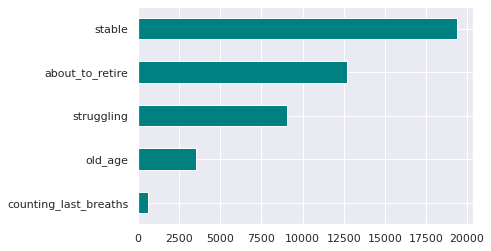

In [ ]:
df['cat_age'].value_counts().sort_values(ascending =  True).plot(kind = 'barh',color = 'teal');

In [ ]:
# job

def cluster_jobs(job):
  new_cat1 = ['technician','services']
  new_cat2 = ['blue-collar','admin.']
  new_cat3 = ['self-employed','housemaid','entrepreneur']
  if job in new_cat1:
    return 'cat1'
  if job in new_cat2:
    return 'cat2'
  if job in new_cat3:
    return 'cat3'
  return job

In [ ]:
df['new_jobs'] = df['job'].apply(cluster_jobs)

In [ ]:
#default
df.has_credit_card.replace({'no': 0,'yes': 1},inplace = True)

#housing
df.housing.replace({'no': 0,'yes':1 },inplace = True)

#loan default
df.loan.replace({'no': 0,'yes': 1},inplace = True)

#contact
df.contact.replace({'unknown': 0, 'cellular': 1, 'telephone': 1},inplace = True)

In [ ]:
df['contacted_before'] = df['pdays'].apply(lambda x : 1 if x != -1 else 0 )

In [ ]:
df['prev_outcome'] = df['prev_outcome'].apply(lambda x: 1 if x == 'success' else 0)

In [ ]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})

In [ ]:
df.drop(['age', 'job', 'pdays'], axis = 1, inplace = True)

In [ ]:
pd.set_option('display.max_columns', None)
final_df = pd.get_dummies(df, columns = ['marital', 'cat_age', 'new_jobs'], drop_first = True, prefix = 'status')

final_df.head()

,education,has_credit_card,balance,housing,loan,contact,day,month,duration,campaign,previous,prev_outcome,y,contacted_before,status_married,status_single,status_counting_last_breaths,status_old_age,status_stable,status_struggling,status_cat2,status_cat3,status_management,status_retired,status_student,status_unemployed,status_unknown
0,3,0,2143,1,0,0,5,5,261,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
1,2,0,29,1,0,0,5,5,151,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2,0,2,1,1,0,5,5,76,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
3,0,0,1506,1,0,0,5,5,92,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,5,5,198,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
print('Bank Marketting Effectiveness dataset after Label Encoding and Feature Engineering - rows:', 
      final_df.shape[0],' columns:', final_df.shape[1])

Bank Marketting Effectiveness dataset after Label Encoding and Feature Engineering - rows: 45211  columns: 27


In [ ]:
# Independent and Dependent variables separation 

X = final_df.drop('y', axis = 1)
y = final_df['y']

###Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,
                                        criterion ='entropy', 
                                         max_features = 2)
  
# Training the model
extra_tree_forest.fit(X, y)
  
# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_
  
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_],
                                        axis = 0)

In [ ]:
features = X.columns

In [ ]:
feature_df = pd.DataFrame({'Features': features, 'Value': feature_importance_normalized})
feature_df = feature_df.sort_values(by = ['Value'], ascending = False)

In [ ]:
#Top 15 features

feature_df = feature_df.head(15) 

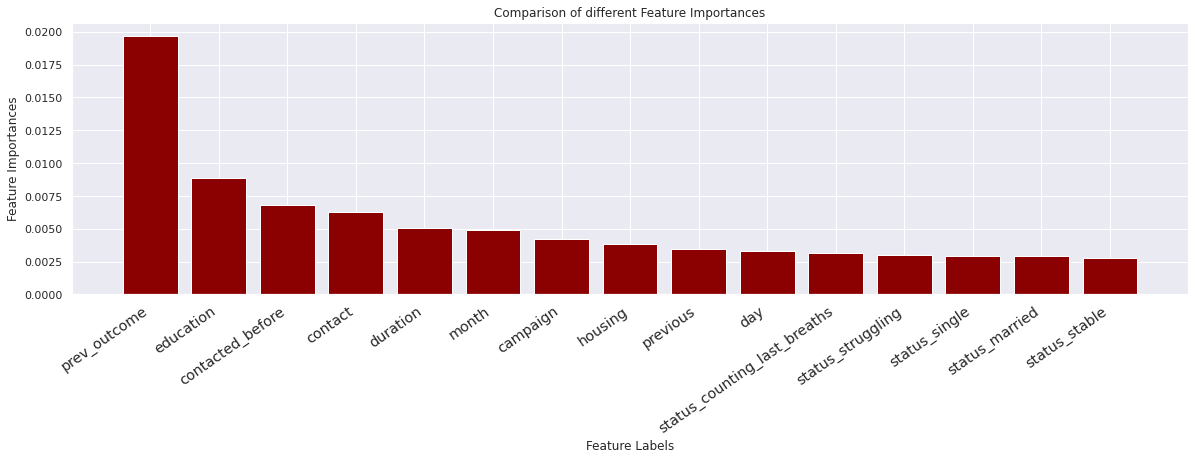

In [ ]:
# Plotting a Bar Graph to compare the model features
plt.figure(figsize = (20, 5))
plt.bar(feature_df['Features'], feature_df['Value'],color = 'Darkred')
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.xticks(
    rotation = 35, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'large');
plt.show()

In [ ]:
list_cols = list(feature_df['Features'])

# Considering only the top 15 features
X = final_df[list_cols]

In [ ]:
# Dependent variable biasness treatment - SMOTE Oversampling

from imblearn.over_sampling import SMOTE
sampler = SMOTE()

X_smote, Y_smote = sampler.fit_resample(X,y)

In [ ]:
# Original length and Resmapled Length

print('Original dataset length', len(X))
print('Resampled dataset length', len(X_smote))

Original dataset length 45211
Resampled dataset length 79844


In [ ]:
# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size = 0.20, random_state = 1)

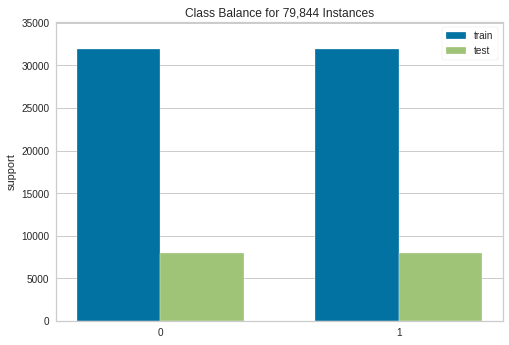

In [ ]:
# Visual inspection about train and test split of dependent variable

from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels = [0, 1])
visualizer.fit(y_train, y_test)
visualizer.poof();

## Logistic Regression 

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred_lr = clf_lr.predict(X_test)

print(f'Train Accuracy = {accuracy_score(y_train, clf_lr.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred_lr)}')

Train Accuracy = 0.8535577299412915
Test Accuracy = 0.854468031811635


Correlation Matrix

[[6808 1177]
 [1147 6837]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

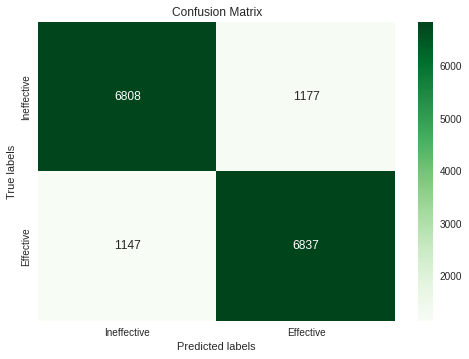

In [ ]:
# Confusion matrix for the Logistic Regression Model

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Greens', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Classification Report for the Logistic Regression Model

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      7985
           1       0.85      0.86      0.85      7984

    accuracy                           0.85     15969
   macro avg       0.85      0.85      0.85     15969
weighted avg       0.85      0.85      0.85     15969



Interpretation: Of the entire test set, 85% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 85% of the customer’s preferred term deposits that were promoted.

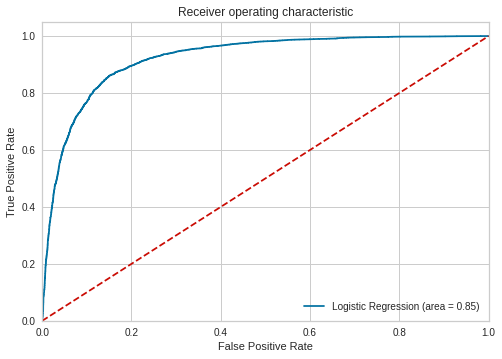

In [ ]:
# roc_auc curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, clf_lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Since a good classifier stays as far away from that line as possible we can assume that our model works fine

## DecisionTree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(max_leaf_nodes = 10, max_depth = 5, random_state = 0)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=0)

In [ ]:
y_pred_dt = clf_dt.predict(X_test)

[[5979 2006]
 [1042 6942]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

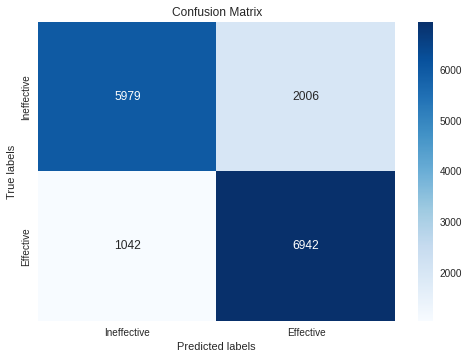

In [ ]:
# Confusion matrix for the DecisionTree Classifier

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred_dt)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Blues', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Train and test accuracy

print(f'Train Accuracy = {accuracy_score(y_train, clf_dt.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred_dt)}')

Train Accuracy = 0.8158904109589041
Test Accuracy = 0.8091301897426263


### The model is optimum because train and test accuracy both are 82% approximately.

In [ ]:
# Classification report for the DecisionTree Classifier

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      7985
           1       0.78      0.87      0.82      7984

    accuracy                           0.81     15969
   macro avg       0.81      0.81      0.81     15969
weighted avg       0.81      0.81      0.81     15969



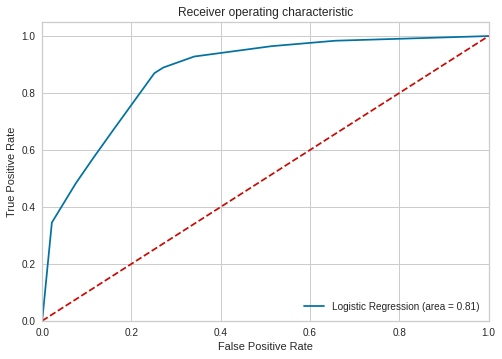

In [ ]:
dt_roc_auc = roc_auc_score(y_test, clf_dt.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_dt.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('cr_dt_ROC')
plt.show()

In [ ]:
!pip install graphviz

In [ ]:
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

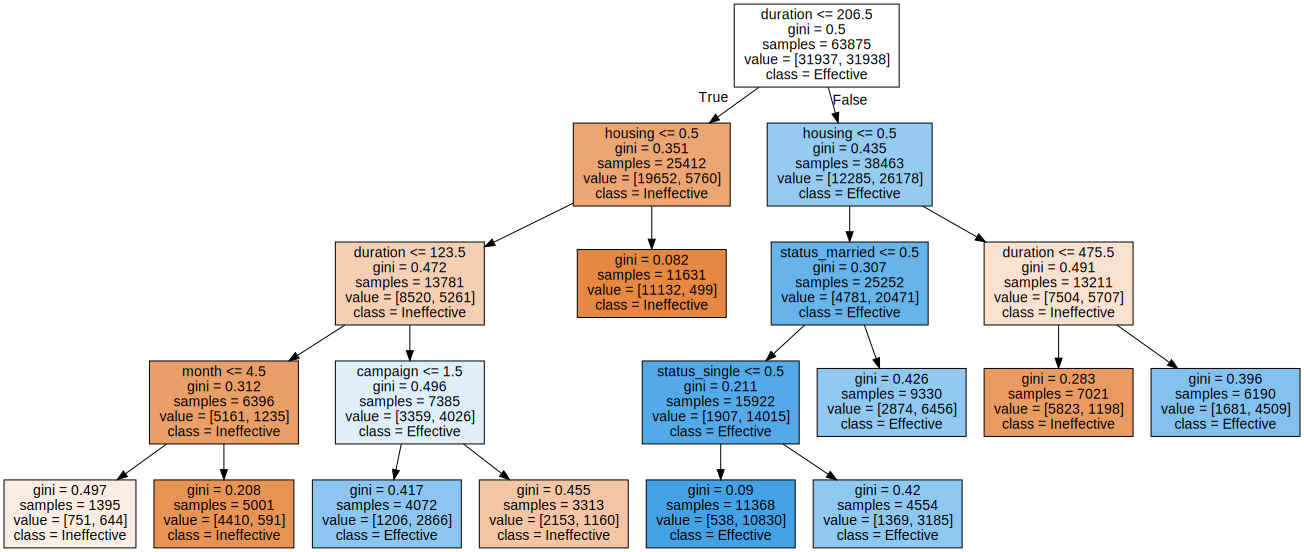

In [ ]:
graph = Source(tree.export_graphviz(clf_dt, out_file = None
   , feature_names = list_cols, class_names = ['Ineffective', 'Effective'] 
   , filled = True))
display(SVG(graph.pipe(format = 'svg')))

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the RandomForestClassifier
clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

In [ ]:
# Train and test accuracy

print(f'Train Accuracy = {accuracy_score(y_train, clf_rf.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred)}')

Train Accuracy = 0.9999060665362035
Test Accuracy = 0.9282985784958356


[[7243  742]
 [ 403 7581]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

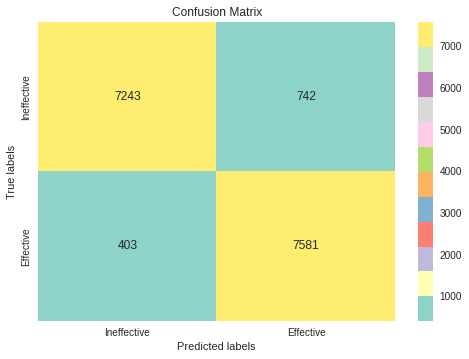

In [ ]:
# Confusion matrix for the RandomForest Classifier

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Set3', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Classification report for the RandomForest Classifier

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7985
           1       0.91      0.95      0.93      7984

    accuracy                           0.93     15969
   macro avg       0.93      0.93      0.93     15969
weighted avg       0.93      0.93      0.93     15969



In [ ]:
clf_rf.feature_importances_

array([0.00972446, 0.01671532, 0.13139388, 0.11211748, 0.02419723,
       0.36225508, 0.08945124, 0.02030258, 0.04551172, 0.06185598,
       0.0456486 , 0.01456713, 0.03342406, 0.02501449, 0.00782075])

In [ ]:
df_impt = pd.DataFrame({'features': X_train.columns,'importance': clf_rf.feature_importances_})
df_impt = df_impt.sort_values(by = 'importance', ascending = False)
df_impt

,features,importance
5,duration,0.362255
2,balance,0.131394
3,housing,0.112117
6,day,0.089451
9,status_married,0.061856
10,status_stable,0.045649
8,previous,0.045512
12,loan,0.033424
13,status_struggling,0.025014
4,education,0.024197


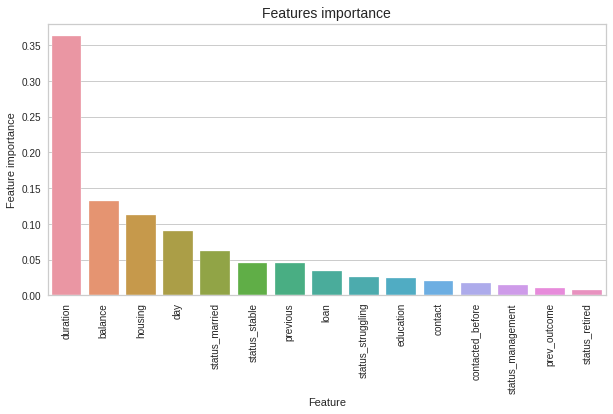

In [ ]:
tmp = pd.DataFrame({'Feature': X_train.columns, 'Feature importance': clf_rf.feature_importances_})
tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
plt.figure(figsize = (10, 5))
plt.title('Features importance', fontsize = 14)
s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
# Number of trees
n_estimators = [50, 100, 200, 250]

# Maximum depth of trees
max_depth = [5, 10, 15]

# Minimum number of samples required to split a node
min_samples_split = [50, 100, 150, 200]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40, 50, 60]

# Hyperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
param_dict

{'max_depth': [5, 10, 15],
 'min_samples_leaf': [40, 50, 60],
 'min_samples_split': [50, 100, 150, 200],
 'n_estimators': [50, 100, 200, 250]}

In [ ]:
# Implementating RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Create an instance of the RandomForestClassifier
clf_rf = RandomForestClassifier()

# Random search
random_rf = RandomizedSearchCV(estimator = clf_rf,
                       param_distributions = param_dict,
                       cv = 5, 
                       verbose = 2, 
                       scoring = 'roc_auc',
                       n_iter = 5)

random_rf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=10, min_samples_leaf=40, min_samples_split=50, n_estimators=200; total time=   6.0s
[CV] END max_depth=10, min_samples_leaf=40, min_samples_split=50, n_estimators=200; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=40, min_samples_split=50, n_estimators=200; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=40, min_samples_split=50, n_estimators=200; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=40, min_samples_split=50, n_estimators=200; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=150, n_estimators=200; total time=   5.7s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=150, n_estimators=200; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=150, n_estimators=200; total time=   7.8s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=150, n_estimators=200; total time=   8.2s
[CV] END 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_leaf': [40, 50, 60],
                                        'min_samples_split': [50, 100, 150,
                                                              200],
                                        'n_estimators': [50, 100, 200, 250]},
                   scoring='roc_auc', verbose=2)

In [ ]:
# Best estimator for the random forest

random_rf.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_leaf=40, min_samples_split=100,
                       n_estimators=50)

In [ ]:
random_rf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 40,
 'min_samples_split': 100,
 'n_estimators': 50}

In [ ]:
rf_optimal_model = random_rf.best_estimator_

In [ ]:
y_pred_rf = rf_optimal_model.predict(X_test)

In [ ]:
# Train and test accuracy

print(f'Train Accuracy = {accuracy_score(y_train, rf_optimal_model.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred_rf)}')

Train Accuracy = 0.8935420743639921
Test Accuracy = 0.887782578746321


[[6849 1136]
 [ 847 7137]]


[Text(0, 0.5, 'Ineffective'), Text(0, 1.5, 'Effective')]

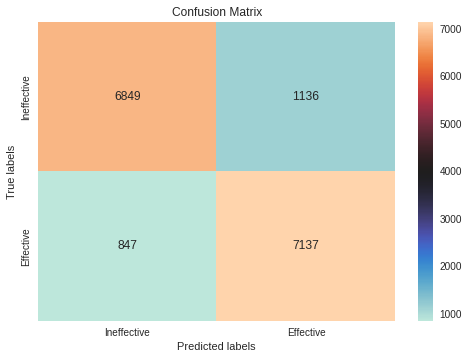

In [ ]:
# Confusion matrix for the RandomForest Classifier

from sklearn.metrics import confusion_matrix

labels = ['Ineffective', 'Effective']
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'icefire', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Classification report for the RandomForest Classifier

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      7985
           1       0.86      0.89      0.88      7984

    accuracy                           0.88     15969
   macro avg       0.88      0.88      0.88     15969
weighted avg       0.88      0.88      0.88     15969



In [ ]:
!pip install xgboost

## XGBRF  Classifier

In [ ]:
import xgboost as xg

# Instantiation
xgb_r = xg.XGBRFClassifier(learning_rate = 0.01, n_estimators = 100, seed = 0)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
y_pred_xgbrf = xgb_r.predict(X_test)

In [ ]:
print(f'Train Accuracy = {accuracy_score(y_train, xgb_r.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_pred_xgbrf)}')

Train Accuracy = 0.8234520547945205
Test Accuracy = 0.8165195065439289


## XGBoost Classifier

In [ ]:
# Instantiation
xgb_C = xg.XGBClassifier(n_estimators = 100, seed = 123)
  
# Fitting the model
xgb_C.fit(X_train, y_train)


# Predict the model
y_ored_xgb = xgb_C.predict(X_test)

print(f'Train Accuracy = {accuracy_score(y_train, xgb_C.predict(X_train))}')
print(f'Test Accuracy = {accuracy_score(y_test, y_ored_xgb)}')

Train Accuracy = 0.8926497064579256
Test Accuracy = 0.8878452000751456


In [ ]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(['SL No.',"Model_Name",'Train_Accuracy', "Test_Accuracy"]) 
  
# Add rows 
myTable.add_row(['1',"Logistic Regression", "85.36%", "85.45%"]) 
myTable.add_row(['2',"Decision Tree ", "81.59%", "80.91%"])
myTable.add_row(['3',"RanodmForest Classifier ", "99%", "92.83%"]) 
myTable.add_row(['4',"RadomizedSearchCV RandomForest Classifier", "89.35%", "88.7%"]) 
myTable.add_row(['5',"Xgbrf Classifier", "82.35%", "81.65%"])
myTable.add_row(['6',"Xgboost Classifier", "89.26%", "88.78%"])

print(myTable)

+--------+-------------------------------------------+----------------+---------------+
| SL No. |                 Model_Name                | Train_Accuracy | Test_Accuracy |
+--------+-------------------------------------------+----------------+---------------+
|   1    |            Logistic Regression            |     85.36%     |     85.45%    |
|   2    |               Decision Tree               |     81.59%     |     80.91%    |
|   3    |          RanodmForest Classifier          |      99%       |     92.83%    |
|   4    | RadomizedSearchCV RandomForest Classifier |     89.35%     |     88.7%     |
|   5    |              Xgbrf Classifier             |     82.35%     |     81.65%    |
|   6    |             Xgboost Classifier            |     89.26%     |     88.78%    |
+--------+-------------------------------------------+----------------+---------------+


In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 8.4 MB/s 


In [ ]:
import shap

In [ ]:
shap.initjs()

In [ ]:
X_shap = X_train
explainer = shap.TreeExplainer(rf_optimal_model)
shap_values = explainer.shap_values(X_shap)

In [ ]:
X_shap.shape

(63875, 15)

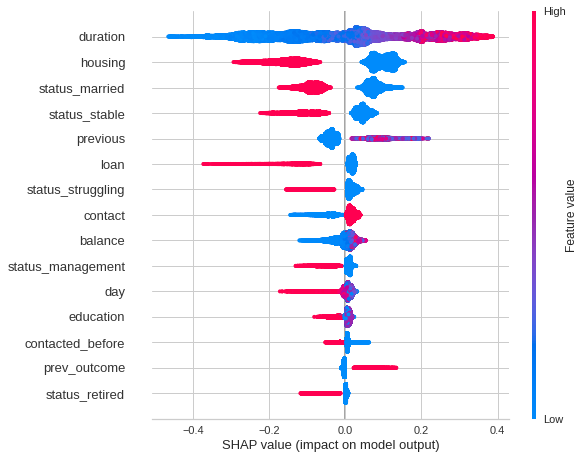

In [ ]:
shap.summary_plot(shap_values[1], X_shap, plot_type='dot')

In [ ]:
x_shap = X_test
explainer_test = shap.TreeExplainer(rf_optimal_model)
shap_values_test = explainer_test.shap_values(x_shap)

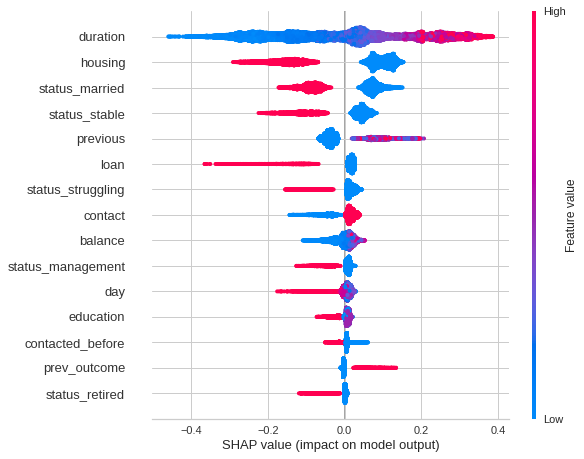

In [ ]:
shap.summary_plot(shap_values_test[1], x_shap, plot_type='dot')

## Interactions Beteeen Features - Dependence Plot

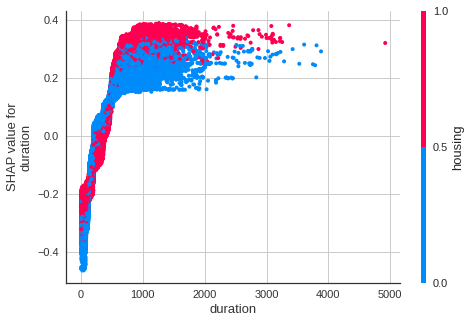

In [ ]:
shap.dependence_plot("duration", shap_values[1], X_train)

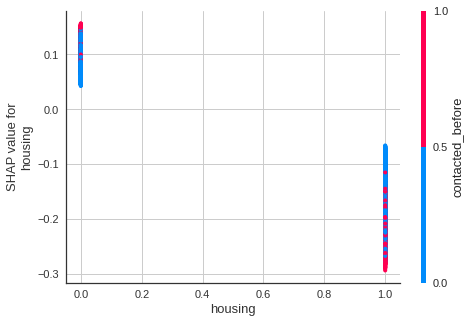

In [ ]:
shap.dependence_plot("housing", shap_values[1], X_train)

###Local interpretibility

In [ ]:
index = 0
shap.force_plot(explainer_test.expected_value[1],
                shap_values_test[1][index,:],
                X_test.iloc[index,:])

In [ ]:
index = 106
shap.force_plot(explainer_test.expected_value[1],
                shap_values_test[1][index,:],
                X_test.iloc[index,:])

In [ ]:
index = 256
shap.force_plot(explainer_test.expected_value[1],
                shap_values_test[1][index,:],
                X_test.iloc[index,:])

In [ ]:
index = 600
shap.force_plot(explainer_test.expected_value[1],
                shap_values_test[1][index,:],
                X_test.iloc[index,:])